# Rede Neural para _Part-of-Speech_ em Português
## Aprenizado de Máquina

Maria Luísa Costa Pinto

# Introdução

Em lingüística, _Part-of-Speech_ (etiquetagem de POS ou etiquetagem de PoS ou POST), também chamada de marcação gramatical ou desambiguação de categoria de palavra, é o processo de marcação de uma palavra em um texto (_corpus_) como correspondente a uma parte específica de discurso, baseado em sua definição e seu contexto, ou seja, sua relação com palavras adjacentes e relacionadas em uma frase, frase ou parágrafo. Uma forma simplificada disso é comumente ensinada a crianças em idade escolar, na identificação de palavras como substantivos, verbos, adjetivos, advérbios, etc.

Uma vez realizada manualmente, a marcação de _tags_ também é feita no contexto da linguística computacional, usando algoritmos que associam termos discretos, bem como partes ocultas da fala, de acordo com um conjunto de tags descritivos. Existem diferentes técnicas para POS Tagging:

**Métodos baseados em léxico** -
Atribui a tag à ocorrência mais frequente de uma palavra no corpus de treinamento.

**Métodos baseados em Regras** - 
Atribui tags com base em regras. Por exemplo, podemos ter uma regra que diz que palavras terminadas em "er" ou "ar" devem ser atribuídas a um verbo.

**Métodos probabilísticos** - 
Esse método atribui as tags com base na probabilidade de ocorrência de uma sequência de tag específica. Os Campos Aleatórios Condicionais (CRFs) e os Modelos de Markov Ocultos (HMMs) são abordagens probabilísticas para atribuir a tags POS.

**Métodos de Aprendizagem Profunda** -
Redes Neurais Recorrentes também podem ser usadas para marcação de pos tagging.

Part-of-Speech tagging é uma tarefa bem conhecida no Processamento de Linguagem Natural. Neste trabalho será apresentado um modelo de Rede Neural profunda para resolver o problema de pos-tagging na língua portuguesa. Esta abordagem se concentra em uma _Multilayer Perceptron Network_ que é uma arquitetura de rede muito popular, considerada como o estado da arte em problemas como este.

## Bibliotecas necessárias

In [1]:
#
# Importanto bibliotecas necessárias
#

import nltk
from nltk.corpus import floresta
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from nltk.corpus.reader import *
from sklearn import feature_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from IPython.display import Image
import random

from sklearn import svm
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection
from sklearn import naive_bayes
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

Using TensorFlow backend.


## Base de dados

Foi utilizada a base de dados _Floresta Sintá(c)tica_. É um conjunto crescente de sentenças de textos em português (81.000 palavras) dos corpus CETEMPúblico e CETENFolha onde as palavras estão taggeadas. 

Chamamos de "Floresta Sintáctica" um conjunto de frases (corpus) analisadas (morfo)sintaticamente. Como, além da indicação das funções sintácticas, a análise também explicita hierarquicamente informação relativa à estrutura de constituintes, dizemos que uma frase sintaticamente analisada se parece com uma árvore, donde um conjunto de árvores constitui uma floresta sintáctica (em inglês, treebank). O projecto Floresta Sintá(c)tica é uma colaboração entre a Linguateca e o projecto VISL. Contém textos em português (do Brasil e de Portugal) anotados (analisados) automaticamente pelo analisador sintáctico PALAVRAS (Bick 2000) e revistos por linguistas.

O corpus  _Floresta Sintá(c)tica_ serve para o treino e avaliação de analisadores morfossintácticos, para estudos baseados em corpos e para investigação da língua, não apenas da sintaxe, mas também de aspectos semânticos e discursivos. 

Fonte: https://www.linguateca.pt/Floresta/

In [2]:
nltk.download('floresta')
from nltk.corpus import floresta

[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Unzipping corpora/floresta.zip.


Para visualizar os dados será exibida uma frase aleatória da base, que contém o conjunto de (palavra, _tag_).

In [3]:
#
# Exibicao dos dados
#

sentences = floresta.tagged_sents()
columns = ['word', 'tag']
rdn_sentence = random.choice(sentences)
print('Random sentence: \n-> {}'.format(rdn_sentence))

print('Table sentence')

pd.DataFrame(rdn_sentence, columns=columns)

Random sentence: 
-> [('Fontes', 'H+n'), ('fidedignas', 'N<+adj'), ('que', 'ACC+pron-indp'), ('o', '>N+art'), ('mesmo', 'H+pron-det'), ('é', 'P+v-fin'), ('dizer', 'P+v-inf'), (',', ','), ('não', '>A+adv'), ('jornalísticas', 'N<+adj'), ('garantiram', 'P+v-fin'), ('entretanto', 'ADVL+adv'), ('que', 'SUB+conj-s'), (',', ','), ('entre', 'H+prp'), ('as', '>N+art'), ('frases', 'H+n'), ('atribuídas', 'P+v-pcp'), ('a', 'H+prp'), ('o', '>N+art'), ('senhor', 'H+n'), ('primeiro-ministro', 'N<+n'), ('que', 'SUBJ+pron-indp'), (',', ','), ('de', 'H+prp'), ('facto', 'P<+n'), (',', ','), ('lhe', 'DAT+pron-pers'), ('não', 'ADVL+adv'), ('pertencem', 'P+v-fin'), ('estão', 'P+v-fin'), ('o', '>N+art'), ('comentário', 'H+n'), ('a', 'H+prp'), ('o', '>N+art'), ('congresso', 'H+n'), ('«', '«'), ('Portugal_e_o_futuro', 'N<+prop'), (',', ','), ('a', '>N+art'), ('resposta', 'H+n'), ('a', 'H+prp'), ('o', '>N+art'), ('deputado', 'H+n'), ('Adriano_Moreira', 'N<+prop'), ('quando', 'ADVL+adv'), ('este', 'SUBJ+pron-det

,word,tag
0,Fontes,H+n
1,fidedignas,N<+adj
2,que,ACC+pron-indp
3,o,>N+art
4,mesmo,H+pron-det
5,é,P+v-fin
6,dizer,P+v-inf
7,",",","
8,não,>A+adv
9,jornalísticas,N<+adj


O _Floresta Sintá(c)tica_ é na verdade um conjunto de várias árvores na qual as frases são "quebradas" em partes até que as palavras (os nós) recebem tags, que são na verdade uma combinação de todas as tags que foram encontradas.

![](https://homepages.dcc.ufmg.br/~maria.luisa/machine_learning/arvore_floresta.png)



## Tamanho das sentenças

Abaixo são mostrados os tamanhos das sentenças encontradas no dataset.

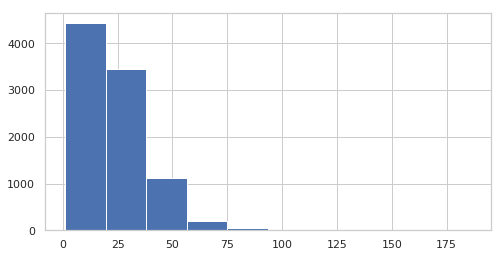

In [4]:
plt.figure(figsize=(8,4))
plt.hist([len(s) for s in sentences])
plt.show()

## Tags do _corpus_

O corpus _Floresta Sintá(c)tica_ possui uma série de tags diferentes, contemplando aspectos referentes a:

*   Classe das palavas
*   Questões sintáticas e moforlógicas
*   Tags de inflexão (Gênero, número, primeira pessoa, segunda pessoa...)

As tags vão além de definir se uma palavra é verbo, substantivo, etc. A descrição completa das tags pode ser encontrada na documentação oficial da base de dados:

*   http://www.linguateca.pt/floresta/doc/PALAVRAStagset.html
*   http://www.linguateca.pt/floresta/doc/VISLsymbolset-manual.html

In [5]:
#
# Exibição das tags encontradas
#

tags = set([tag for sentence in sentences for _, tag in sentence])
print('Total de tags encontradas: {}\ntags: {}'.format(len(tags), tags))

Total de tags encontradas: 269
tags: {'FOC+adv', 'PRT-AUX<+pp', 'AUX+v-ger', 'PAUX+v-ger', 'VOK+n', 'P<+n', 'PMV+v-fin', 'N<PRED+pron-det', 'P<+adv', 'ADV+adv', 'CJT&PRED+adj', 'N</ADVL[-3]+adv', 'P<+v-pcp', 'P<+adj', 'ACC+in', '>N+pron-indp', '>N+pron-det', '?+?', 'ADVL+v-inf', '>N+n', 'N<+num', 'PMV+v-pcp', 'H+adj', 'CJT+pron-indp', 'VOK+prop', 'APP+prop', 'CJT+in', 'P<+num', 'SC+adv', '?', 'CJT+v-pcp', 'CJT&ADVL+adv', '>N+pron-pers', 'N<PRED+pron-indp', 'QUE+n', '[', '>N+prp', 'SUBJ+adv', 'CJT+v-ger', '>A+adv', 'PAUX+v-inf', "N<{'185/60_R_14'}", 'PRT-AUX+prp', 'CJT+adj', 'CJT+n', '>N+pp', '.', '>A+v-pcp', 'P<+pron-det', 'AS<+pron-det', ',', '?+n', 'P<+prop', '«', '>A+pron-indp', '>N+prop', 'VOC+n', 'AS<+prop', 'P<+pron-indp', 'SC+pron-det', 'N</N<[+2]+adv', 'ADVO+adv', 'SC+pp', 'P+v-fin', 'H+conj-s', 'SUBJ+prop', 'ACC+num', 'PRT-AUX<+prp', 'SUBJ+pron-det', 'P<+v-inf', 'STA+v-fin', 'PMV+v-inf', 'ADVL+conj-s', 'SUBJ+conj-s', 'PRD+adv', 'H+num', 'H+pron-pers', 'VOC+pron-pers', '>A+adj'

## Simplificando as tags do _Floresta Sintá(c)tica_

As tags consistem em alguma informação sintatica, seguida por um sinal "+", seguido por uma tag convencional de part-of-speech (também conhecidas como _grammatical tagging_,  análise/classificação gramatical. São elas:
*   noun, verb, article, adjective, preposition, pronoun, adverb, conjunction, and interjection,
*   substantivo, verbo, artigo, adjetivo, preposição, pronome, adverbo, conjução e interjeição)

Neste trabalho vamos cortar vamos cortar fora a parte antes do sinal de adição e considerar apenas as tags referentes a informação gramatical.

In [0]:
#
# Trata casos específicos
#

def special_cases(t):
  # tags erradas encontradas
  if (t == '2]+adv'):
    return 'adv'
  if (t == ''):
    return '-'
  # todas as terminacoes verbais do floresta
  if (t == 'fin' or t == 'inf' or t == 'pcp' or t == 'ger' or t == 'vp'):
    return 'v'
  
  # todas as terminacoes de pronomes do floresta
  if (t == 'pers' or t == 'det' or t == 'indp'):
    return 'pron'
  
  # todas as terminacoes de conjuncoes do floresta
  if (t == 'c' or t == 's'):
    return 'conj'
  # preposições do floresta tratadas como conjuntos de tags
  if (t == 'pp'):
    return 'prp'
  return t

#
#  Simplifica a tag encontrada no corpus utilizado
#
#

def simplify_tag(t):
    if '+' in t:
        t = t[t.index('+') + 1:]
        if '-' in t:
          t = t[t.index('-') + 1:]
          return special_cases(t)
        else:
          return special_cases(t)
    else:
      if (t.isalpha() and len(t) == 1):
        return special_cases(t)
      else:
        return '-'

### Limpeza das tags

Veja como ficaram as tags após a limpeza:

In [7]:
#
#  Limpeza das tags
# 

tags = [simplify_tag(tag) for sentence in sentences for _, tag in sentence]

unique_tags = list(dict.fromkeys(tags))
print('Total de tags encontradas: {}\ntags: {}'.format(len(unique_tags), unique_tags))

Total de tags encontradas: 14
tags: ['art', 'n', 'adj', 'prop', 'v', 'prp', '-', 'num', 'adv', 'pron', 'conj', 'in', 'ec', '?']


### Descrição das tags simplificadas

1. **ART**: Artigos
2. **N** : Nomes 
3. **ADJ**: Adjetivos (incluindo ordinais, excluindo particípios que são marcados como V PCP) 
4. **PROP**: Nomes próprios 
5. **V**: Verbos 
6. **PRP**: Preposições 
7. **-**: Pontuações
8. **NUM**: Números 
9. **ADV**: Advérbios (advérbios 'primários' e advérbios derivados terminados em -mente) 
10. **PRON**: Pronomes
11. **CONJ**: Conjunções
12. **IN**: Interjeições 
13. **EC**:  Prefixo separado por hífen ("elemento composto", categoria sendo eliminada, mas ainda existe na base)
14. **?**: Tags não identificadas

Fonte: https://www.linguateca.pt/floresta/doc/PALAVRAStagset.html



## Base de dados após a simplificação das tags

Conforme já citado anteriormente, o _ Floresta Sintá(c)tica_ possui uma quantidade de tags muito grande e complexo, que contempla uma série de aspectos relacionados a formação de uma frase.

Neste trabalho vamos utilizar apenas as informações das classes gramaticais das palavras, assim,  as sentenças foram atualizadas para conter apenas a tag referente a classe gramatical da palavra.

In [0]:
#
#   Altera a tag nas sentencas
#
#

def update_tag_in_setence(sent):
  new_sent = [(w, simplify_tag(t)) for (w, t) in sent]
  return new_sent


# nova variavel com as classes limpas
clean_sentences = [update_tag_in_setence(sentence) for sentence in sentences]

# atualiza a variavel de sentencas
sentences = clean_sentences

Os dados foram novamente exibidos, desta vez no formato final que será usado para treinar e avaliar o modelo desenvolvido.


In [9]:
#
#  Exibe uma sentença randomica depois da limpeza das tags
#

rdn_sentence = random.choice(clean_sentences)
print('Random sentence: \n-> {}'.format(rdn_sentence))

print('Table sentence')

for index, tuple in rdn_sentence:
   if(len(tuple[0]) > 0 and tuple[0] == ',' 
      and len(tuple[1]) > 0 and tuple[1] == ','):
     rdn_sentence.remove(index)

pd.DataFrame(rdn_sentence, columns=columns)

Random sentence: 
-> [('A', 'art'), ('Folha', 'n'), ('procurou', 'v'), ('falar', 'v'), ('com', 'prp'), ('Melodia', 'prop'), ('sobre', 'prp'), ('o', 'art'), ('incidente', 'n'), ('.', '-')]
Table sentence


,word,tag
0,A,art
1,Folha,n
2,procurou,v
3,falar,v
4,com,prp
5,Melodia,prop
6,sobre,prp
7,o,art
8,incidente,n
9,.,-


Abaixo é mostrado um exemplo da utilização das tags após a simplificação das tags iniciais do corpus.

![alt text](https://homepages.dcc.ufmg.br/~maria.luisa/machine_learning/pos_tagger.png)

### Frequência das tags encontradas na base de dados

Abaixo são listas as tags e a frequência na qual as mesmas são encontradas no _corpus_.

In [10]:
#
#  Frequencia das tags encontradas
#

# tabela com a frequência
frequence_tags = nltk.FreqDist(tags).most_common()
columns = ['Tag', 'Frequência']
pd.DataFrame(frequence_tags, columns=columns)

,Tag,Frequência
0,n,40081
1,prp,32839
2,art,29360
3,-,29161
4,v,26333
5,prop,11652
6,pron,10998
7,adj,10725
8,adv,9097
9,conj,7403


<Figure size 576x576 with 0 Axes>

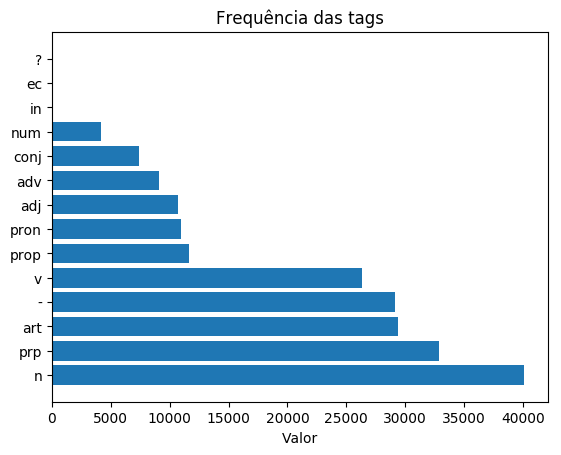

In [11]:
# grafico com a frequencia
plt.figure(figsize=(8,8))
plt.rcdefaults()
fig, ax = plt.subplots()

tags_g = [t for (t, f) in frequence_tags]
frequences = [f for (t, f) in frequence_tags]

y_pos = np.arange(len(tags_g))
error = np.random.rand(len(tags_g))

ax.barh(y_pos, frequences, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(tags_g)
ax.set_xlabel('Valor')
ax.set_title('Frequência das tags')

plt.show()

## Representando os dados por meio das características

O dado utilizado é **não estruturado**, assim foi realizada uma extração de características dos dados a fim de estruturar o dado para servir de entrada para a rede neural. 

O conjunto de _features_ definido foi muito simples.
Para cada termo, foi definida uma lista de características, dependendo da frase em que o termo foi extraído.
Essas características podem incluir informações sobre palavras anteriores e próximas, além de prefixos e sufixos.

In [0]:
#
#  Insere as características básicas
#
#  : paramêtro sentence_terms: [w1, w2, ...]
#  : paramêtro index: o índice da palavra
#  : returna: dicionário contendo recursos
#
#

def add_nlp_features(sentence_terms, index):
    term = sentence_terms[index]
    len_term = len(term)

    if(len_term == 0):
      term = " "
    
    return {
        'term': term,
        'len_term': len(term),
        'len_sentence': len(sentence_terms),
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_first_cap': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix_1': term[0],
        'prefix_2': term[:2],
        'prefix_3': term[:3],
        'suffix_1': term[-1],
        'suffix_2': term[-2:],
        'suffix_3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

Foi mapeada a lista de sentenças para uma lista características.

In [0]:
#
#  Funcao auxiliar que remove a tag da tupla em uma sentença
#
#  : parâmetro tagged_sentence: uma frase com tags
#  : retorna: uma lista de tags
#

def remove_tag(tagged_sentence):
    return [w for w, _ in tagged_sentence]

In [0]:
#
#  Divide as frases marcadas nos conjuntos de dados X e y e inclua as características
#
#  : parâmetro tagged_sentences: uma lista de frases marcadas, tuplas (termo, tag)
#  : retorna: X e y
#  

def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):

            # Adicionar características básicas de NLP para cada sentença
            X.append(add_nlp_features(remove_tag(pos_tags), index))
            y.append(class_)
    return X, y

In [15]:
sample_x, sample_y = transform_to_dataset(sentences)

columns = ['term', 'len_term', 'len_sentence', 'is_first', 'is_last', 'is_first_cap', 'is_all_caps', 'is_all_lower', 'prefix_1', 'prefix_2', 'prefix_3', 'suffix_1', 'suffix_2', 'suffix_3', 'prev_word', 'next_word']
pd.DataFrame(sample_x, columns=columns)

,term,len_term,len_sentence,is_first,is_last,is_first_cap,is_all_caps,is_all_lower,prefix_1,prefix_2,prefix_3,suffix_1,suffix_2,suffix_3,prev_word,next_word
0,Um,2,3,True,False,True,False,False,U,Um,Um,m,Um,Um,,revivalismo
1,revivalismo,11,3,False,False,False,False,True,r,re,rev,o,mo,smo,Um,refrescante
2,refrescante,11,3,False,True,False,False,True,r,re,ref,e,te,nte,revivalismo,
3,O,1,10,True,False,True,True,False,O,O,O,O,O,O,,7_e_Meio
4,7_e_Meio,8,10,False,False,True,False,False,7,7_,7_e,o,io,eio,O,é
5,é,1,10,False,False,False,False,True,é,é,é,é,é,é,7_e_Meio,um
6,um,2,10,False,False,False,False,True,u,um,um,m,um,um,é,ex-libris
7,ex-libris,9,10,False,False,False,False,True,e,ex,ex-,s,is,ris,um,de
8,de,2,10,False,False,False,False,True,d,de,de,e,de,de,ex-libris,a
9,a,1,10,False,False,False,False,True,a,a,a,a,a,a,de,noite


## Relações entre as features

Abaixo estão _plotados_ relacionamentos de pares em no conjunto de dados.

Por padrão, essa função criará uma grade de Eixos de forma que cada variável nos dados será compartilhada no eixo y em uma única linha e no eixo x em uma única coluna. Os Eixos diagonais são tratados de maneira diferente, desenhando um gráfico para mostrar a distribuição univariada dos dados para a variável nessa coluna.


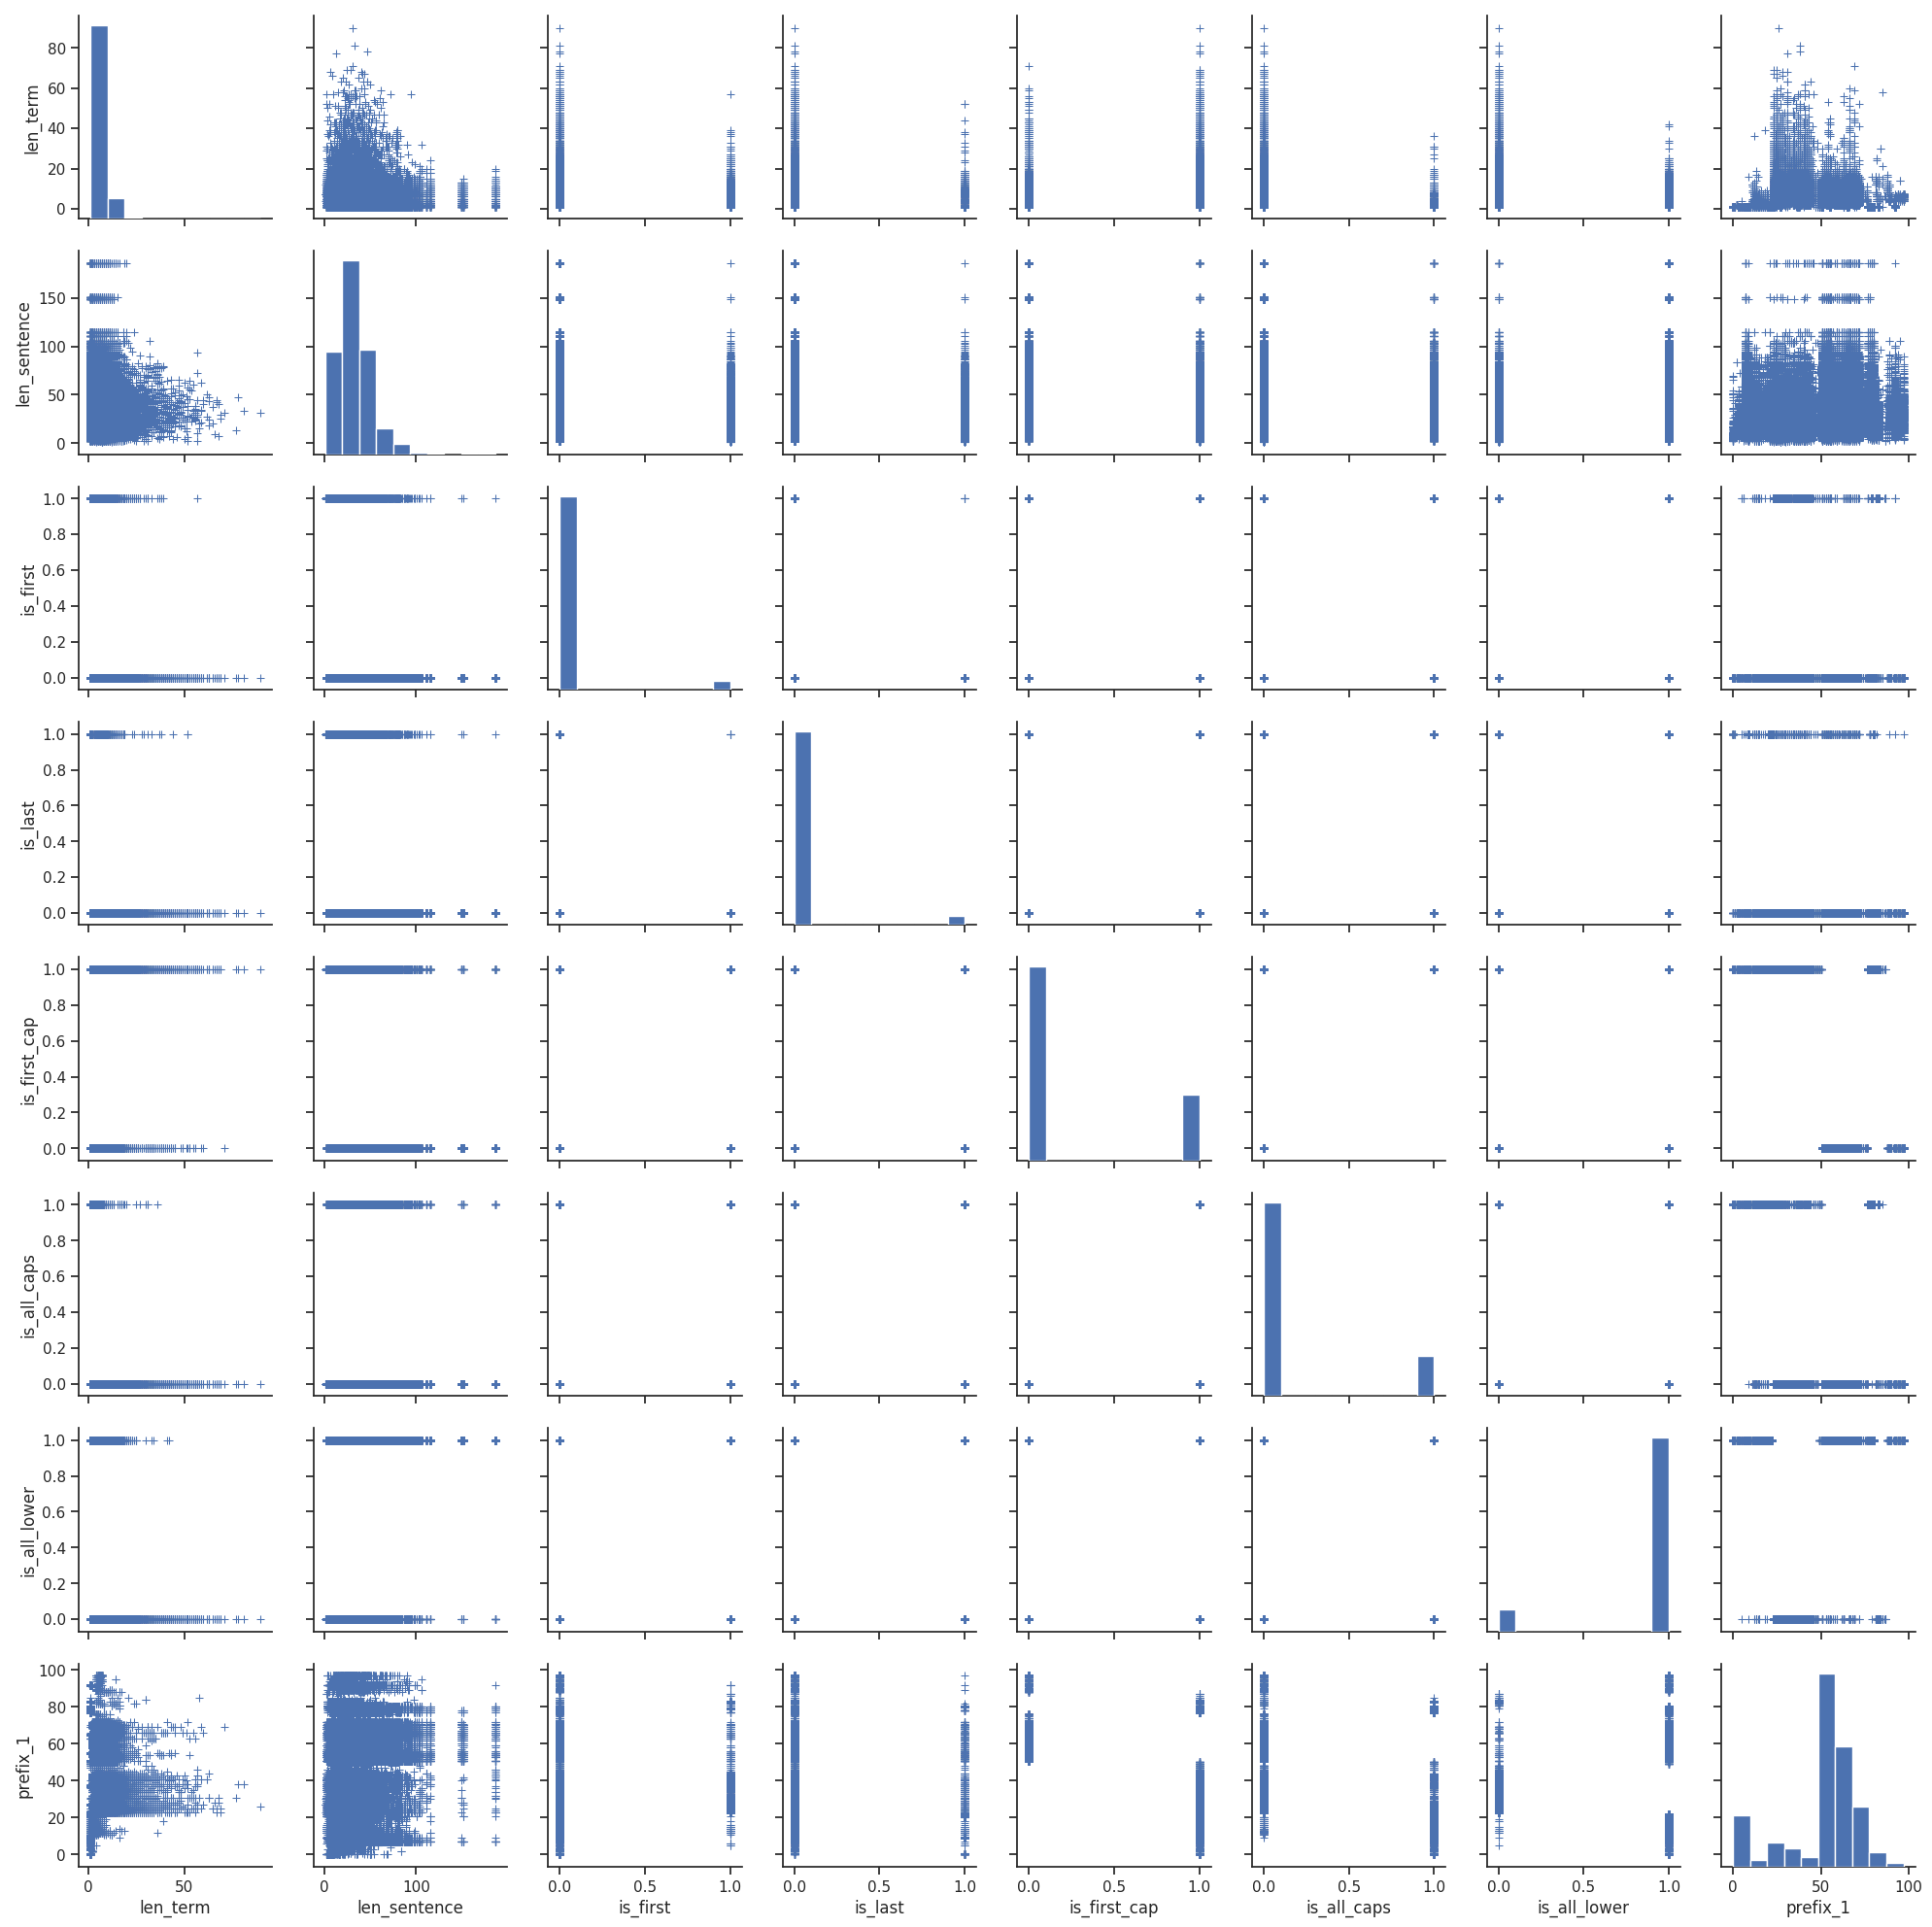

In [16]:
df_sns = pd.DataFrame(sample_x, columns=columns)

lab_enc = LabelEncoder()

def convert_to_values(feature):
  lab_enc.fit(df_sns[feature])
  variable = lab_enc.transform(df_sns[feature])
  return variable

df_sns['is_first'] = convert_to_values('is_first')
df_sns['is_last'] = convert_to_values('is_last')
df_sns['is_first_cap'] = convert_to_values('is_first_cap')
df_sns['is_all_caps'] = convert_to_values('is_all_caps')
df_sns['is_all_lower'] = convert_to_values('is_all_lower')
df_sns['prefix_1'] = convert_to_values('prefix_1')
df_sns['prefix_1'] = convert_to_values('prefix_1')

sns.set(style="ticks", color_codes=False)
sns.pairplot(df_sns, palette="husl", markers="+", vars=['len_term', 'len_sentence', 'is_first', 'is_last', 'is_first_cap', 'is_all_caps', 'is_all_lower', 'prefix_1'])

Text(0.5, 1.0, 'Correlation Matrix')

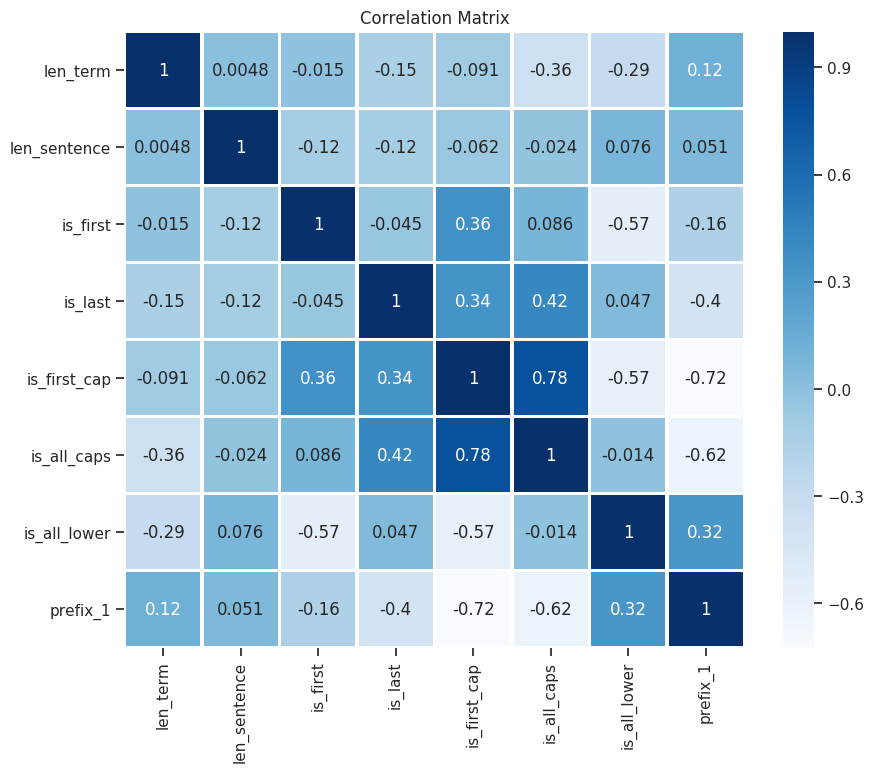

In [17]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_sns.corr(),linewidths=2.0, ax=ax , annot=True, cmap="Blues")
ax.set_title('Correlation Matrix')

## Tranformando das características em vetores

A rede neural usa vetores como entradas, por isso precisamos converter nossas características em vetores.
O _DictVectorizer_ fornece uma maneira simples de fazer isso.

In [0]:
X_featured_sentences, y_featured_sentences = transform_to_dataset(sentences)

X = X_featured_sentences
y = y_featured_sentences

A rede neural usa vetores como entradas, por isso as características foram convertidas em vetores.

In [0]:
dict_vectorizer = DictVectorizer(sparse=True)
dict_vectorizer.fit(X)
X_vect = dict_vectorizer.transform(X)

Codificando os vetores

In [20]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(y)

array([ 4,  8,  2, ...,  0, 11,  0])

Convertendo os valores inteiros em variáveis do modelo

In [0]:
y_enc = label_encoder.transform(y)
y_dummy = np_utils.to_categorical(y_enc)

## Modelo

A ideia é criar um modelo de Perceptron Multicamadas para o problema de Pos Tagging. Esse tipo de pilha linear de camadas pode ser facilmente feito com o modelo Sequential. Este modelo conterá uma camada de entrada, uma camada oculta e uma camada de saída.
Para superar o problema de _overfitting_, será usada a regularização do abandono. A taxa de desistência foi definida para 20%, o que significa que 20% dos neurônios selecionados aleatoriamente são ignorados durante o treinamento em cada ciclo de atualização.

A função de ativação usada foi a  _Rectified Linear Units_ (ReLU) para as camadas ocultas, pois é uma função de ativação não linear simples.

A função _softmax_ foi usada para converter as saídas das unidades em probabilidades, o que é comum em classificação de várias classes.

O otimizador usado foi o _Adam_, pois ele parece ser bem adequado para tarefas de classificação.

In [0]:
#
#  Construindo o Modelo
#
# : parâmetro input_dim: dimensão da entrada
# : parâmetro hidden_neurons: neurônios ocultos
# : parâmetro input_dim: dimensão da saida
# : retorna o modelo
#

def build_model(input_dim, hidden_neurons, output_dim):
    
    model = Sequential()
    model.add(Dense(hidden_neurons, activation='sigmoid', input_dim=input_dim))
    model.add(Dropout(0.4))
    model.add(Dense(hidden_neurons, activation='sigmoid'))
    model.add(Dropout(0.4))
    model.add(Dense(output_dim, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Abaixo são definidos todos os parâmetros do modelo. O número de neurônios ocultos e o tamanho do lote são escolhidos arbitrariamente. Foi definido o número de épocas para 5, porque foi considerado que com mais iterações o Multilayer Perceptron começa a obter _overfitting_.

In [0]:
# Parâmetros do modelo

model_params = {
    'build_fn': build_model,
    'input_dim': X_vect.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_dummy.shape[1],
    'epochs': 30,
    'batch_size': 128,
    'verbose': 1,
    'shuffle': True
}

## Criando um classificador com o modelo criado

In [0]:
clf_nn = KerasClassifier(**model_params)

## Usando validação cruzada

In [0]:
cv_n_splits = 3
cv = KFold(n_splits=cv_n_splits)

## Visualização de perda e precisão em relação ao tempo
Foi gerado um gráfico mostrando a perda e a precisão do modelo em relação ao número de épocas

In [0]:
#
#  Função que gera o grafico da perda
#

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    blue = '#0067B0'
    pink = '#DA3C78'

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5,
             label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, pink,
             linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Loss', fontweight='bold')

    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5,
             label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, pink,
             linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Accuracy', fontweight='bold')

    plt.tight_layout()
    plt.savefig('result_acc_.png')
    plt.show()

## Treino e Validação do modelo

W0630 23:52:53.612686 140634960623488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 23:52:53.645817 140634960623488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 23:52:53.652918 140634960623488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 23:52:53.668475 140634960623488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0630 23:52:53.676894 

Train on 98863 samples, validate on 42371 samples
Epoch 1/30
98863/98863 [==============================] - 101s 1ms/step - loss: 0.6757 - acc: 0.7788 - val_loss: 0.2022 - val_acc: 0.9333
Epoch 2/30
98863/98863 [==============================] - 96s 972us/step - loss: 0.2059 - acc: 0.9301 - val_loss: 0.1452 - val_acc: 0.9506
Epoch 3/30
98863/98863 [==============================] - 96s 972us/step - loss: 0.1418 - acc: 0.9526 - val_loss: 0.1310 - val_acc: 0.9555
Epoch 4/30
98863/98863 [==============================] - 96s 970us/step - loss: 0.1083 - acc: 0.9641 - val_loss: 0.1268 - val_acc: 0.9585
Epoch 5/30
98863/98863 [==============================] - 96s 972us/step - loss: 0.0859 - acc: 0.9723 - val_loss: 0.1266 - val_acc: 0.9588
Epoch 6/30
98863/98863 [==============================] - 96s 968us/step - loss: 0.0708 - acc: 0.9768 - val_loss: 0.1220 - val_acc: 0.9614
Epoch 7/30
98863/98863 [==============================] - 96s 968us/step - loss: 0.0595 - acc: 0.9805 - val_loss: 0.1

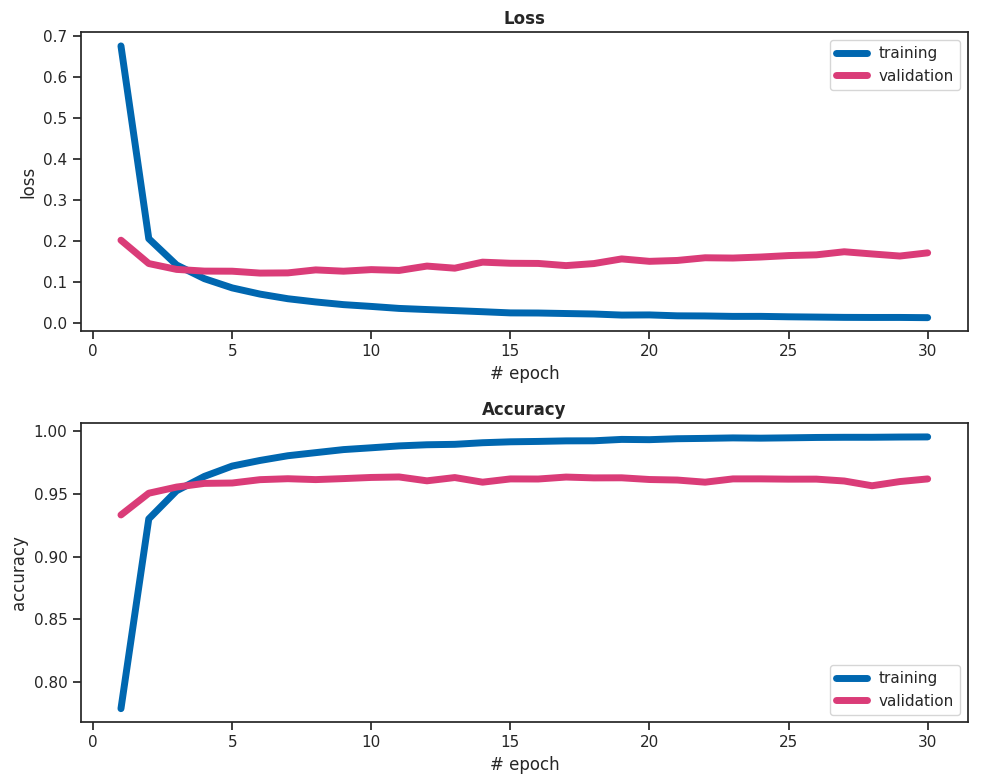

[0.9333034386726771, 0.9506266078213873, 0.9555356257817847, 0.9584621557197139, 0.9587689693422388, 0.9614358877534163, 0.9621911212857851, 0.9614830898491893, 0.9622855254773311, 0.9632059663449057, 0.9635835831110902, 0.9605154468858418, 0.9631115621533596, 0.9594297986830616, 0.9620259139505795, 0.9619551108069199, 0.9635127799674306, 0.9628519506266078, 0.9629227537702674, 0.9615538929928489, 0.9611290741308914, 0.9594297986830616, 0.9620495149984659, 0.9620731160463525, 0.9618371055674872, 0.9618607066153737, 0.9603738405985226, 0.9565740718887918, 0.9599254206886786, 0.9620259139505795]
model accuracy: 0.9584950012390128
70618/70618 [==============================] - 34s 487us/step
model predicts: [ 4  8  2 ...  8 13 12]

-----

Train on 98864 samples, validate on 42371 samples
Epoch 1/30
98864/98864 [==============================] - 96s 976us/step - loss: 0.6881 - acc: 0.7750 - val_loss: 0.2097 - val_acc: 0.9301
Epoch 2/30
98864/98864 [==============================] - 95s 964

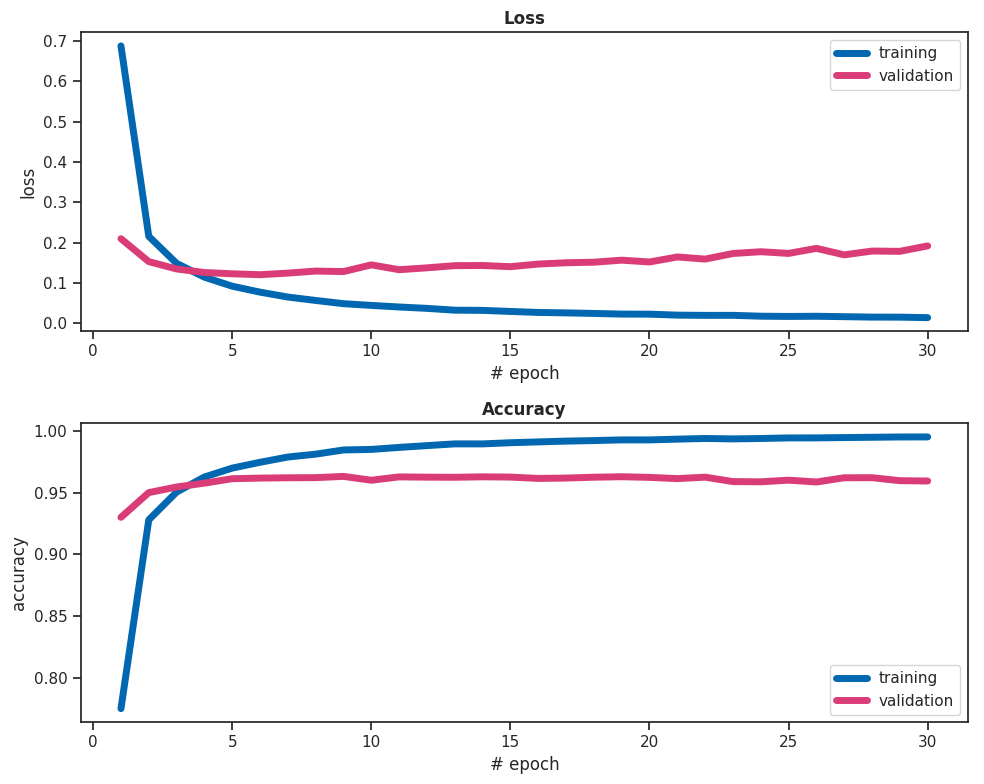

[0.9300700951122229, 0.9501309858157703, 0.9546859880578697, 0.9578013263788913, 0.9613886856576432, 0.9618843076632603, 0.9621439191900121, 0.9622619244294447, 0.9632767694885653, 0.9601378301196574, 0.9628755516744943, 0.9626395411956291, 0.962545137004083, 0.9629227537702674, 0.9627103443392887, 0.9616246961365085, 0.9619315097590333, 0.9625923390998561, 0.962993556913927, 0.9624743338604234, 0.9614830898491893, 0.9626395411956291, 0.9590521819168771, 0.9588869745816714, 0.9602086332633168, 0.9587217672464657, 0.9621675202378985, 0.9622147223336717, 0.9597838144013594, 0.9595242028746076]
model accuracy: 0.9582678391922401
70617/70617 [==============================] - 34s 488us/step
model predicts: [10  8  0 ...  0 10 13]

-----

Train on 98864 samples, validate on 42371 samples
Epoch 1/30
98864/98864 [==============================] - 98s 992us/step - loss: 0.6808 - acc: 0.7760 - val_loss: 0.2218 - val_acc: 0.9237
Epoch 2/30
98864/98864 [==============================] - 97s 980us

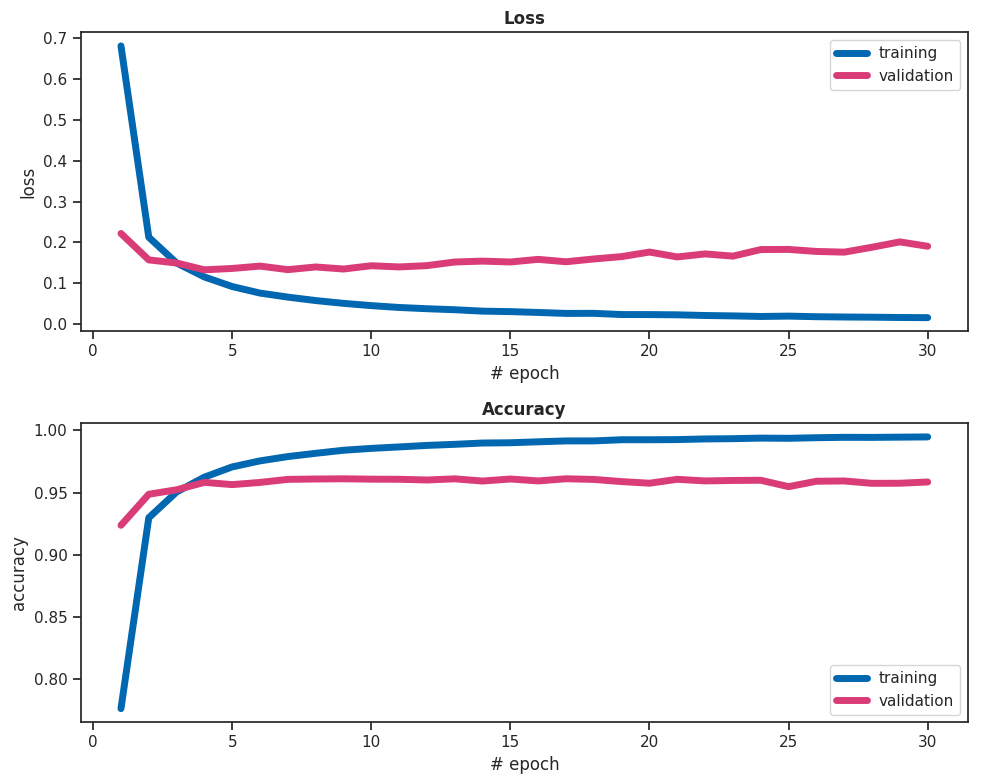

[0.9236506100870878, 0.948644119798919, 0.9522550801255576, 0.9582261452408487, 0.9564088645535862, 0.9581789431450757, 0.9606334521252744, 0.9609402657477992, 0.9611054730830049, 0.96079865946048, 0.960704255268934, 0.9601378301196574, 0.9610582709872318, 0.9592881923957424, 0.9609402657477992, 0.9593825965872885, 0.9611290741308914, 0.9605862500295013, 0.9588397724858984, 0.9575417148521395, 0.9606806542210474, 0.9593825965872885, 0.959760213353473, 0.9599254206886786, 0.9547567912015293, 0.9591229850605367, 0.959358995539402, 0.9574473106605933, 0.9575181138042529, 0.9585329588633735]
model accuracy: 0.9499978758790897
70617/70617 [==============================] - 35s 490us/step
model predicts: [12  4 11 ...  0 11  0]

-----



In [27]:
# Criação do classificador a partir do modelo

# salva os resultados da rede neural
r_neural_network = []

# validacao cruzada
for train, test in cv.split(X_vect, y_dummy):
    hist = clf_nn.fit(X_vect[train], y_dummy[train], validation_split=0.3)

    # Plot a performance do modelo
    plot_model_performance(
        train_loss=hist.history.get('loss', []),
        train_acc=hist.history.get('acc', []),
        train_val_loss=hist.history.get('val_loss', []),
        train_val_acc=hist.history.get('val_acc', [])
    )
    
    print(hist.history.get('val_acc', []))

    # Avaliando a acurácia do modelo 
    score = clf_nn.score(X_vect[test], y_dummy[test], verbose=0)
    print('model accuracy: {}'.format(score))

    # Computa as predições do modelo
    y_preds = clf_nn.predict(X_vect[test])
    print('model predicts: {}'.format(y_preds))

    # Nome das classes
    target_names = label_encoder.classes_
    
    vls_acc = hist.history.get('acc', [])
    vls_v_acc = hist.history.get('val_acc', [])
    r_neural_network.append([vls_acc[len(vls_acc)-1], vls_v_acc[len(vls_v_acc)-1]])
    print('\n-----\n')
    

# salva o score da rede neural
s_neural_network = score


## Visualizando a arquitetura do modelo


Abaixo é mostrada a arquitetura do modelo e em seguida o modelo é salvo em um arquivo.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               49939968  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 14)                7182      
Total params: 50,209,806
Trainable params: 50,209,806
Non-trainable params: 0
_________________________________________________________________


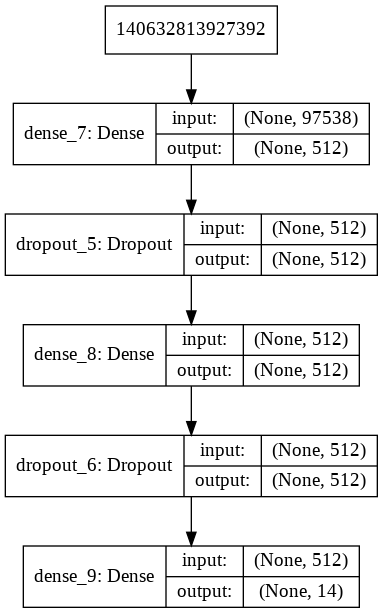

In [28]:
# Resumo do modelo
clf_nn.model.summary()

# Visualize model architecture
plot_model(clf_nn.model, to_file='model_structure.png', show_shapes=True)
Image(filename='model_structure.png')

# Comparando o resultado com outros métodos

Além de ter desenvolvido a rede neural, este trabalho também fez uma comparação com outro(s) modelo(s) existente(s) na literatura. Isso foi feito, pois uma vez que a extração de características foi feita, agora temos um dado estruturado e pode-se executar métodos clássicos de aprendizado supervisionado como SVM, Naive Bayes, Decision Tree e Random Forest.

Neste trabalho foi feita uma comparação com o Decision Tree.

In [0]:
def evaluation_method(classifier):
  results = []
  for train, test in cv.split(X_vect, y_dummy):
    hist = classifier.fit(X_vect[train], y_dummy[train])
    
    y_pred = classifier.predict(X_vect[test])
    train_acc = classifier.score(X_vect[train],  y_dummy[train])
    test_acc = classifier.score(X_vect[test],  y_dummy[test])
    
    results.append([train_acc, test_acc])
    print('---')
    print("Acuracia de treino: {:.3}".format(train_acc))
    print("Acuracia de validação: {:.3}".format(test_acc))
  return results

## Árvore de decisão

In [30]:
clf_dt = DecisionTreeClassifier(max_depth=100)

r_dt = evaluation_method(clf_dt)

---
Acuracia de treino: 0.991
Acuracia de validação: 0.936
---
Acuracia de treino: 0.99
Acuracia de validação: 0.941
---
Acuracia de treino: 0.992
Acuracia de validação: 0.937


## Visualização do resultado dos métodos

In [0]:
blue = '#0067B0'
pink = '#DA3C78'

def show_values_models(array_nn, array_dt, text):
  n_groups = cv_n_splits
  fig, ax = plt.subplots()
  index = np.arange(n_groups)
  bar_width = 0.15
  opacity = 0.8

  rects1 = plt.bar(index, array_nn, bar_width,
  alpha=opacity,
  color=pink,
  label='Neural Network')

  rects2 = plt.bar(index + bar_width, array_dt, bar_width,
  alpha=opacity,
  color=blue,
  label='Decision Tree')

  plt.xlabel('cv splits')
  plt.ylabel('Valores')
  plt.title('Comparação dos dois modelos - '+ text)
  plt.xticks(index + bar_width, ('1', '2', '3', '4'))
  plt.legend()

  plt.tight_layout()
  plt.show()

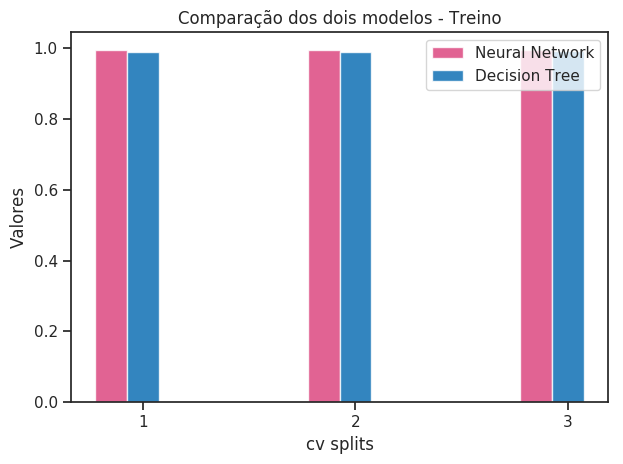

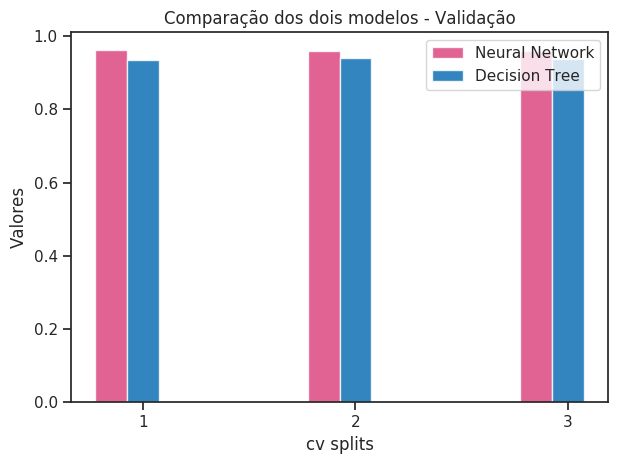

In [32]:
# valores da rede neural
acc_array_nn = [a for [a, va] in r_neural_network]
v_acc_array_nn = [va for [a, va] in r_neural_network]

# valores do decision tree
acc_array_dt = [a for [a, va] in r_dt]
v_acc_array_dt = [va for [a, va] in r_dt]


# Gera os graficos
show_values_models(acc_array_nn, acc_array_dt, 'Treino')
show_values_models(v_acc_array_nn, v_acc_array_dt, 'Validação')

## Resultados e análises gerais

### A base de dados

Com relação a base de dados que foi utilizada no trabalho, inicialmente foi difícil entender como ela funcionava. Embora os próprios criadores do dataset o recomendam para treinar e avaliar modelos que resolvem o problema de pos tagging, a base de dados incialmente pareceu bem confusa. Após a limpeza e tratamento dos dados, consegui ter um bom desempenho utilizando a base de dados.

Os dados são não estruturados e portanto foi necessária a extração de características para estruturar os dados. Desta forma foi feita uma representação com base em características que um termo apresentou na frase em que se encontra, como saber se a palavra é a primeira ou a última da frase, qual a palavra seguinte e qual é a próxima.

Após esta etapa, uma vez que já possuíamos dados estruturados, foi possível desenvolver um modelo de classificação livre e até mesmo comparar com outros modelos classicos para dados estruturados.

A análise inicial dos dados, trouxe um aprendizado interessante e que permitiu fazer vários ajustes no modelo. Por exemplo, antes da limpeza das tags, o dataset Floresta Sintética, possuía 269 tags. Ao treinar e validar a rede neural construída com estas classes, a acurácia foi alta tanto em tempo de treino quanto em tempo de teste. No entanto o tempo para treinar o modelo era muito maior, uma estimativa de 3 vezes maior. E os resultados era difíceis de ser compreendidos.

### Os modelos utilizados

A rede neural construída obteve uma acurácia alta, assim como a árvore de decisão. Isso leva a crer que o problema apresenta baixa complexidade, ou que a geração das características foi muito boa para o problema de classificação. A extração das características trouxe várias análises que permitiam os modelos decidir melhor a classe de uma determinada palavra. A própria língua portuguesa já possui algumas regras que excluem/incluem algumas classes de palavras em situações, exemplo: em nomes próprios a primeira letra em maiúsculo é obrigatória. 

Um ponto a se explorar que não foi possível no trabalho, diz respeito à explicabilidade do modelo, saber de fato quais features contribuíram para uma boa acurácia do modelo em tempo de teste. 

## Aprendizados 

Este trabalho me permitiu colocar em prática conceitos aprendidos na disciplina e me deu contato com ferramentas ainda não exploradas por mim como Python, Jupyter Notebook e Matplotlib. Certamente são conhecimentos que me serão úteis em outros contextos tanto na carreira acadêmica quanto profissional.

Outro ponto importante foi em relação a aplicação do conhecimento sobre redes neurais, algo que antes da disciplina aparentava ser uma "caixa preta" e hoje é algo mais claro, visto que desenvolvi um trabalho que o aplica.

# Referências

* Base de dados
  * https://www.linguateca.pt/Floresta/
  * https://www.linguateca.pt/floresta/doc/PALAVRAStagset.html
  * https://www.linguateca.pt/floresta/doc/VISLsymbolset-manual.html
  
* Trabalhos relacionados
  * http://ufal.mff.cuni.cz/tlt2006/pdf/126.pdf
  * https://arxiv.org/abs/1104.2086
  * http://www.nltk.org/howto/portuguese_en.html
  * https://github.com/fmaruki/Nltk-Tagger-Portuguese
  * https://docs.huihoo.com/nltk/0.9.5/guides/portuguese_en.html
  * http://lxcenter.di.fc.ul.pt/tools/en/LXTaggerEN.html
  
* Referências técnicas
  * https://keras.io/
  * https://www.dobitaobyte.com.br/rede-neural-com-keras-mais-anotacoes/
  * https://matplotlib.org/gallery/index.html
  * https://keras.io/visualization/
  